In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Basic Data Overview

In [3]:
df.shape

(50000, 2)

In [4]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [5]:
df.isnull().sum()

,0
review,0
sentiment,0


In [6]:
df.duplicated().sum() # 418
df.drop_duplicates(inplace=True)

In [7]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

## Text Cleaning

In [8]:
import nltk
from nltk.corpus import stopwords
import re

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get English stopwords
stop_words = set(stopwords.words('english'))

# Convert to lowercase
df['clean_review'] = df['review'].str.lower()

# Remove non-alphabet characters (keep only letters and spaces)
df['clean_review'] = df['clean_review'].str.replace(r'[^a-z ]', '', regex=True)

# Remove extra spaces
df['clean_review'] = df['clean_review'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove stopwords
df['clean_review'] = df['clean_review'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))


df['clean_review'][1]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'wonderful little production br br filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece br br actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life br br realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done'

## Most Common Words


In [9]:
from collections import Counter

# Tokenize all words in positive and negative reviews
positive_words = ' '.join(df[df['sentiment'] == 'positive']['clean_review']).split()
negative_words = ' '.join(df[df['sentiment'] == 'negative']['clean_review']).split()

pos_word_counts = Counter(positive_words).most_common(20)
neg_word_counts = Counter(negative_words).most_common(20)
print("Most Common Words in Positive Reviews:", pos_word_counts)
print("Most Common Words in Negative Reviews:", neg_word_counts)

Most Common Words in Positive Reviews: [('br', 55620), ('film', 39280), ('movie', 35843), ('one', 25990), ('like', 17087), ('good', 14336), ('great', 12659), ('story', 12360), ('see', 11878), ('time', 11732), ('well', 11079), ('also', 10672), ('really', 10663), ('would', 10329), ('even', 9437), ('much', 9007), ('first', 8917), ('films', 8434), ('love', 8382), ('people', 8357)]
Most Common Words in Negative Reviews: [('br', 58338), ('movie', 47014), ('film', 34650), ('one', 24652), ('like', 21581), ('even', 14935), ('good', 14034), ('bad', 13968), ('would', 13497), ('really', 12117), ('time', 11345), ('see', 10451), ('dont', 10143), ('get', 9895), ('much', 9774), ('story', 9593), ('people', 9018), ('could', 8924), ('make', 8914), ('made', 8303)]


### The most common words in positive and negative reviews are too similar. This means that we are picking up generic words (like movie, film, one, like) rather than words that truly differentiate positive and negative sentiment.

- > Solution : using Tfidf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Separate positive and negative reviews
pos_reviews = df[df['sentiment'] == 'positive']['clean_review']
neg_reviews = df[df['sentiment'] == 'negative']['clean_review']

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit on both positive and negative reviews
tfidf_matrix = tfidf.fit_transform(pos_reviews.tolist() + neg_reviews.tolist())

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Split positive and negative
pos_tfidf = tfidf_df.iloc[:len(pos_reviews)].mean().sort_values(ascending=False) # mean() computes the average TF-IDF score for each word across all positive reviews.
neg_tfidf = tfidf_df.iloc[len(pos_reviews):].mean().sort_values(ascending=False)

# What is the Purpose?
# This helps find the most important words in positive vs. negative reviews based on average TF-IDF score.

# Words with high TF-IDF in positive reviews are more unique to positive sentiment.
# Words with high TF-IDF in negative reviews are more unique to negative sentiment.

# Get the top 20 unique words for each sentiment
pos_unique_words = pos_tfidf[~pos_tfidf.index.isin(neg_tfidf.index)].head(20)
neg_unique_words = neg_tfidf[~neg_tfidf.index.isin(pos_tfidf.index)].head(20)

print("Most Unique Words in Positive Reviews:", pos_unique_words)
print("Most Unique Words in Negative Reviews:", neg_unique_words)


Most Unique Words in Positive Reviews: Series([], dtype: float64)
Most Unique Words in Negative Reviews: Series([], dtype: float64)


- > the output is empty! That happened because in pos_tfidf[~pos_tfidf.index.isin(neg_tfidf.index)], all words exist in both positive and negative reviews, so no unique words were found.

In [11]:
# Compute relative importance of words in positive and negative reviews
word_diff = (pos_tfidf - neg_tfidf).sort_values(ascending=False)  # If a word has a higher TF-IDF score in positive reviews, the difference is positive.

# Top 20 words more common in positive reviews
pos_unique_words = word_diff.head(20)

# Top 20 words more common in negative reviews
neg_unique_words = word_diff.tail(20)

print("Most Distinctive Words in Positive Reviews:", pos_unique_words)
print("Most Distinctive Words in Negative Reviews:", neg_unique_words)


Most Distinctive Words in Positive Reviews: great          0.017467
love           0.010641
best           0.010196
excellent      0.008883
wonderful      0.007509
loved          0.006123
life           0.006082
perfect        0.005679
beautiful      0.005635
amazing        0.005457
favorite       0.004989
story          0.004652
brilliant      0.004651
years          0.004626
family         0.004568
world          0.004561
enjoyed        0.004463
performance    0.004406
young          0.004388
highly         0.004286
dtype: float64
Most Distinctive Words in Negative Reviews: thing      -0.006406
money      -0.006641
script     -0.006719
br         -0.006945
like       -0.007117
worse      -0.007222
poor       -0.007317
horrible   -0.007368
dont       -0.007417
stupid     -0.007959
minutes    -0.007984
acting     -0.008180
boring     -0.008227
plot       -0.008635
terrible   -0.009248
awful      -0.009826
waste      -0.010227
movie      -0.014707
worst      -0.015246
bad        -0.0248

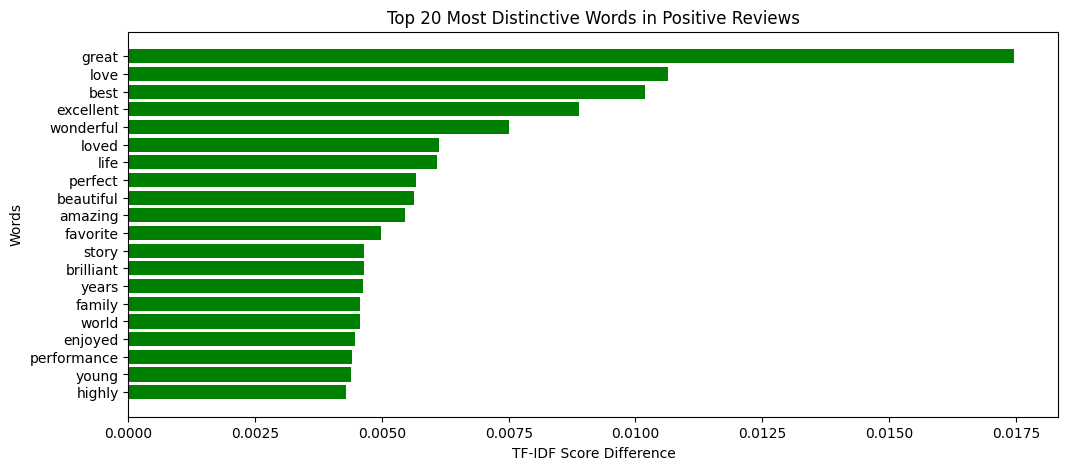

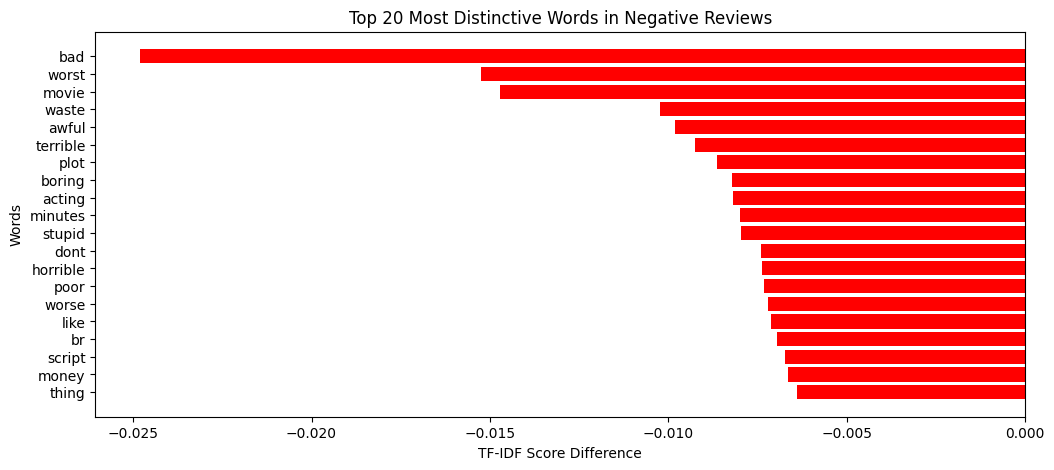

In [12]:
import matplotlib.pyplot as plt

# Extract words and scores for plotting
pos_words, pos_scores = zip(*pos_unique_words.items())  # Positive words
neg_words, neg_scores = zip(*neg_unique_words.items())  # Negative words

# Plot positive words
plt.figure(figsize=(12, 5))
plt.barh(pos_words[::-1], pos_scores[::-1], color='green')
plt.title("Top 20 Most Distinctive Words in Positive Reviews")
plt.xlabel("TF-IDF Score Difference")
plt.ylabel("Words")
plt.show()

# Plot negative words
plt.figure(figsize=(12, 5))
plt.barh(neg_words[::1], neg_scores[::1], color='red')
plt.title("Top 20 Most Distinctive Words in Negative Reviews")
plt.xlabel("TF-IDF Score Difference")
plt.ylabel("Words")
plt.show()


## Length review analysis

In [13]:
df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))
print(df.groupby('sentiment')['review_length'].describe())


             count        mean        std  min   25%   50%    75%     max
sentiment                                                                
negative   24698.0  120.331606  87.734391  3.0  66.0  91.0  146.0   839.0
positive   24884.0  122.974522  95.409205  6.0  64.0  90.0  150.0  1440.0


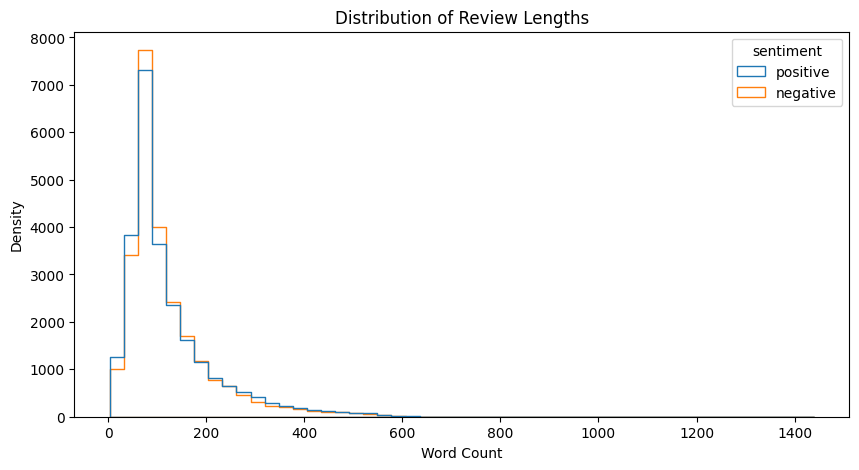

In [14]:
plt.figure(figsize=(10, 5))

sns.histplot(df, x='review_length', hue='sentiment', bins=50, element="step", alpha=0)
plt.title("Distribution of Review Lengths")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.show()


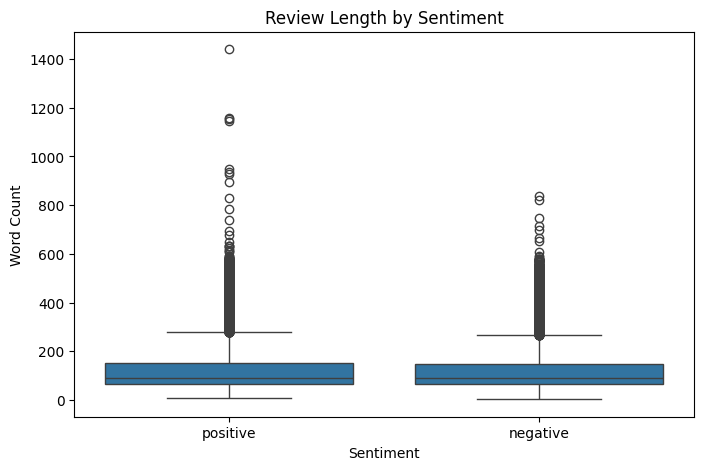

In [15]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title("Review Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()


In [16]:
df['sentiment_numeric'] = df['sentiment'].map({'positive': 1, 'negative': 0})
correlation = df[['review_length', 'sentiment_numeric']].corr()
print(correlation)


                   review_length  sentiment_numeric
review_length           1.000000           0.014415
sentiment_numeric       0.014415           1.000000


## n-grams

In [17]:
from collections import Counter
from nltk.util import ngrams

df['clean_review'] = df['clean_review'].str.replace('br','')

# Get bigrams from positive reviews
positive_bigrams = Counter(ngrams(" ".join(df[df['sentiment'] == 'positive']['clean_review']).split(), 2))
negative_bigrams = Counter(ngrams(" ".join(df[df['sentiment'] == 'negative']['clean_review']).split(), 2))

print(positive_bigrams.most_common(10))
print(negative_bigrams.most_common(10))


[(('one', 'best'), 1642), (('ive', 'seen'), 1097), (('even', 'though'), 1050), (('ever', 'seen'), 944), (('first', 'time'), 923), (('dont', 'know'), 866), (('new', 'york'), 814), (('special', 'effects'), 770), (('see', 'movie'), 740), (('years', 'ago'), 727)]
[(('ever', 'seen'), 1696), (('waste', 'time'), 1389), (('special', 'effects'), 1384), (('looks', 'like'), 1215), (('dont', 'know'), 1197), (('ive', 'seen'), 1112), (('much', 'better'), 980), (('one', 'worst'), 945), (('look', 'like'), 920), (('bad', 'movie'), 872)]


## Lematization

In [18]:
df.head()

,review,sentiment,clean_review,review_length,sentiment_numeric
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,170,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming techniqu...,90,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,87,1
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,70,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,130,1


In [19]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [20]:
from tqdm import tqdm
tqdm.pandas()

def lemmatize_df(df, column_name, new_column_name):
    """Lemmatize text column in a DataFrame using optimized spacy processing."""
    # Process the text in batches using nlp.pipe()
    texts = df[column_name].astype(str).str.lower().tolist()  # Convert to lowercase
    docs = list(tqdm(nlp.pipe(texts, disable=["parser", "ner"]), total=len(texts)))  # Process with progress bar

    # Extract lemmatized text
    df[new_column_name] = [" ".join([token.lemma_ for token in doc]) for doc in docs]
    return df


In [21]:
lemmatize_df(df, 'clean_review', 'Lemmatization')
df.head()

100%|██████████| 49582/49582 [06:50<00:00, 120.68it/s]


,review,sentiment,clean_review,review_length,sentiment_numeric,Lemmatization
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...,170,1,one reviewer mention watch oz episode you ll h...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming techniqu...,90,1,wonderful little production filming techniq...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,87,1,think wonderful way spend time hot summer week...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...,70,0,basically there s family little boy jake think...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,130,1,petter matteis love time money visually stunni...


In [22]:
print(f"Before: {df['clean_review'][1]}")
print(f"After: {df['Lemmatization'][1]}")

Before: wonderful little production   filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece   actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great masters comedy life   realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwells murals decorating every surface terribly well done
After: wonderful little production    filming technique unassume oldtimebbc fashion give comfort sometimes discomforte sense realism entire piece    actor extremely well choose michael sheen get polari voice pat truly see seamless editing guide reference williams diary entry well worth watch terrificly write perform piece maste

## Word Embeddings and Data Splitting

In [23]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

MAX_NUM_WORDS = 15000
MAX_SEQUENCE_LENGTH = 80

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["Lemmatization"])

X_seq = tokenizer.texts_to_sequences(df["Lemmatization"])
X_padded = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

y = df["sentiment_numeric"].values

X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


## Building the model

In [40]:

EMBEDDING_DIM = 100

LSTM_model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, name='Embedding'),
    LSTM(4, return_sequences=False),
    Dense(4, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
LSTM_model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))

LSTM_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)                │ (None, 80, 100)             │       1,500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 4)                   │           1,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,501,705 (5.73 MB)

 Trainable params: 1,501,705 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Train Model with Early Stopping
history = LSTM_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping]
)
test_loss, test_acc = LSTM_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5857 - loss: 0.6689 - val_accuracy: 0.7486 - val_loss: 0.5669
Epoch 2/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7693 - loss: 0.5559 - val_accuracy: 0.8001 - val_loss: 0.5010
Epoch 3/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8092 - loss: 0.4987 - val_accuracy: 0.8076 - val_loss: 0.4883
Epoch 4/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8188 - loss: 0.4588 - val_accuracy: 0.8025 - val_loss: 0.4521
Epoch 5/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8409 - loss: 0.4039 - val_accuracy: 0.8369 - val_loss: 0.4126
Epoch 6/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8685 - loss: 0.3414 - val_accuracy: 0.8255 - val_loss: 0.4157
Epoch 7/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8713 - loss: 0.3300 - val_accuracy: 0.8373 - val_loss: 0.4216
Epoch 8/10
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8836 - loss: 0.3020 - val_accuracy

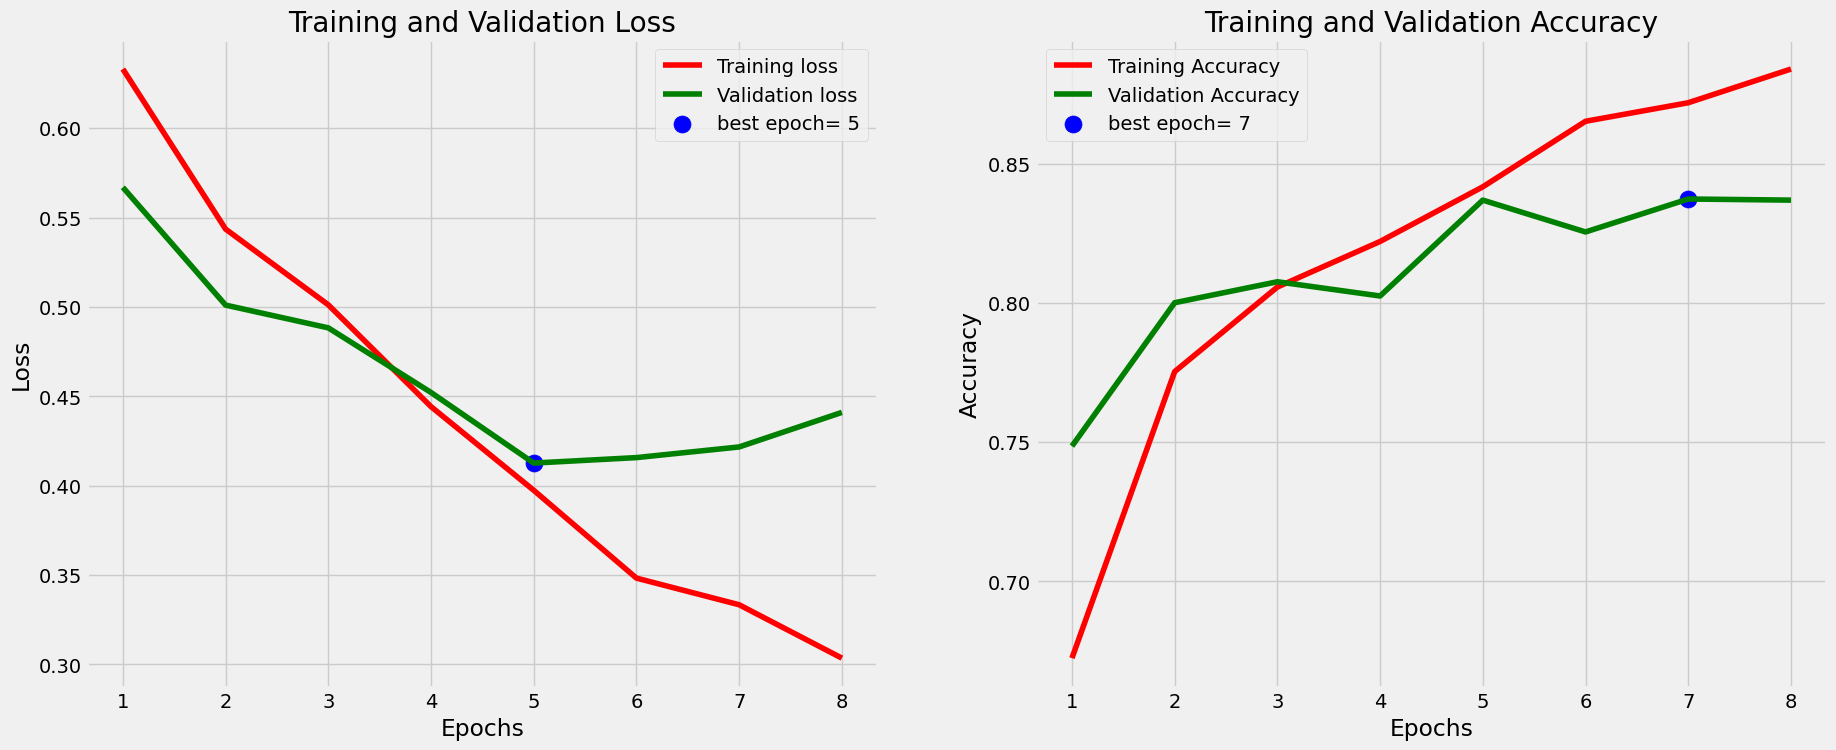

In [42]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [43]:
train_score = LSTM_model.evaluate( X_train, y_train, verbose= 1)
valid_score = LSTM_model.evaluate(X_val, y_val, verbose= 1)
test_score = LSTM_model.evaluate(X_test, y_test, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1085/1085 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9216 - loss: 0.2583
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8421 - loss: 0.4076
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8358 - loss: 0.4175
Train Loss:  0.2592848539352417
Train Accuracy:  0.9216008186340332
--------------------
Validation Loss:  0.4126277565956116
Validation Accuracy:  0.8368965983390808
--------------------
Test Loss:  0.40266698598861694
Test Accuracy:  0.8421618938446045


233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


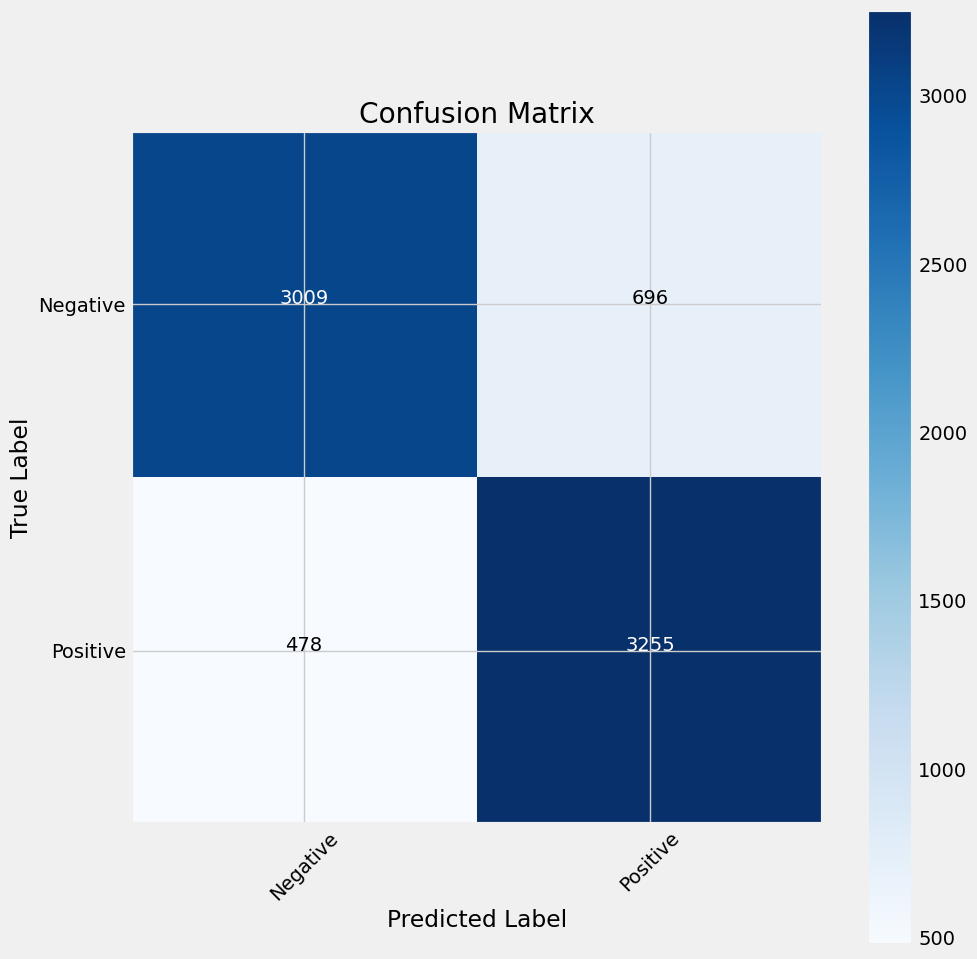

In [44]:
# Confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred_prob = LSTM_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) # Adjust threshold if needed

# Define class labels (replace with your actual class names)
classes = ['Negative', 'Positive']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

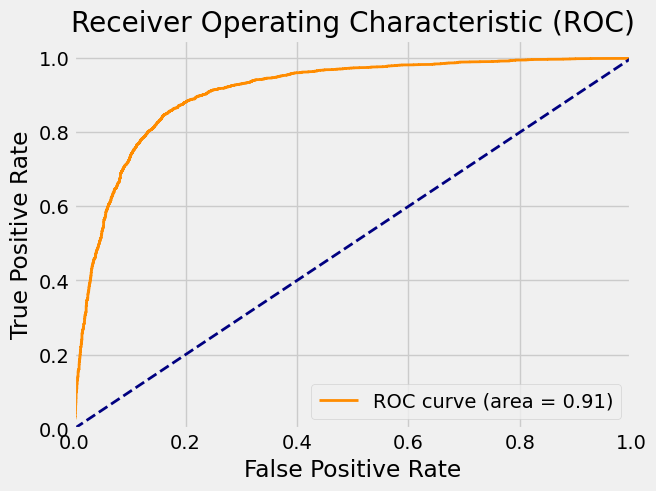

ROC AUC Score: 0.9090834454927114


In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# y_test: true labels
# y_pred_prob: predicted probabilities from your model (e.g., LSTM)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calculate the ROC AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {auc_score}")

In [47]:
# Assuming y_test and y_pred_nb are already defined from your Naive Bayes model
from sklearn.metrics import classification_report
y_pred = (y_pred_prob > 0.5).astype(int)  # You might need to adjust the threshold (0.5)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3705
           1       0.82      0.87      0.85      3733

    accuracy                           0.84      7438
   macro avg       0.84      0.84      0.84      7438
weighted avg       0.84      0.84      0.84      7438



In [48]:
LSTM_model.save("lstm_sentiment_model.keras")

## Testing the model on custom statement

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text(text):
    """Apply the same preprocessing steps as used on the training data."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z ]', '', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords

    # Lemmatization
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc])

    return text

def predict_sentiment(sentence):
    """Predict sentiment for a given input sentence."""
    processed_text = preprocess_text(sentence)  # Preprocess input
    sequence = tokenizer.texts_to_sequences([processed_text])  # Convert to sequence
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

    prediction = LSTM_model.predict(padded_sequence)[0][0]  # Predict sentiment
    sentiment = "Positive" if prediction >= 0.5 else "Negative"

    return sentiment, prediction

# Load the trained model
LSTM_model = tf.keras.models.load_model("lstm_sentiment_model.keras")


In [50]:
sentence = "I gone with my friends to the cinema and watched a movie that was about Harry Potter, a novel that I really like. Although many other people found that the film was boring, I found it great"
sentiment, confidence = predict_sentiment(sentence)
print(f"Sentiment: {sentiment} (Confidence: {confidence:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Sentiment: Positive (Confidence: 0.7387)
